In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import time
from torch.optim.lr_scheduler import StepLR

In [2]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [3]:
def rand_tensor(min=0, max=1, size=(1)):
    out = (max - min) * torch.rand(size) + min
    return out

In [10]:
class Polynomial_func:
    def __init__(self, x, range=[-1,1], degree = 3, size=(1,1), sample_size=100, device="cuda"):
        self.x = x
        self.range = range
        self.degree = degree
        self.size = size
        self.sample_size = sample_size
        self.device = device

    def generate(self):
        hold = []
        for n in range(self.degree + 1):
            p = rand_tensor(
                min=self.range[0],
                max=self.range[1],
                size=(self.sample_size, self.size[0], self.size[1]),
            )
            hold.append(p)
        params = torch.stack(hold)
        params = torch.atleast_2d(params)
        params = torch.transpose(params, 0, 1)
        params = torch.transpose(params, 1, 2)
        params = params.to(self.device)

        x = (
            torch.cat(params.shape[0] * [self.x])
            .reshape(params.shape[0], -1)
            .to(self.device)
        )
        x = torch.transpose(x, 0, 1).to(self.device)
        y = torch.zeros_like(x)

        for d in range(self.degree+1):
            coeffs = params[:,0,d,0]
            y += coeffs*(x**d)
        out = torch.zeros(
                (params.shape[0], self.x.shape[0],
                self.size[0], self.size[1])
            ).to(self.device)            
        out[:,:,0,0] = torch.transpose(y,0,1)
        return (torch.sum(out,dim=3), out), params


In [6]:
def linear_function(params, x, device):
    x = x.to(device)
    if params.size(1) > 1:
        a = params[:, 0].type(torch.float).unsqueeze(1).to(device)
        b = params[:, 1].type(torch.float).unsqueeze(1).to(device)
        return a*x + b
    else:
        return torch.zeros_like(params)

def quadratic_function(params, x, device):
    params = params.to(device)
    x = x.to(device)
    if params.size(1) > 2:
        a = params[:, 0].type(torch.float).unsqueeze(1).to(device)
        b = params[:, 1].type(torch.float).unsqueeze(1).to(device)
        c = params[:, 2].type(torch.float).unsqueeze(1).to(device)
        return a*x**2 + b*x + c
    else:
        return torch.zeros_like(params)

def cubic_function(params, x, device):
    params = params.to(device)
    x = x.to(device)
    if params.size(1) > 3:
        a = params[:, 0].type(torch.float).unsqueeze(1).to(device)
        b = params[:, 1].type(torch.float).unsqueeze(1).to(device)
        c = params[:, 2].type(torch.float).unsqueeze(1).to(device)
        d = params[:, 3].type(torch.float).unsqueeze(1).to(device)
        return a*x**3 + b*x**2 + c*x + d
    else:
        return torch.zeros_like(params)

In [96]:
class Multi_Func(nn.Module):
    def __init__(self, functions, x_data, input_channels, device):
        super().__init__()
        self.device = device
        self.functions = functions  # [[function, (...)], [# params, (...)]]
        self.x_data = x_data
        self.input_channels = input_channels
        self.params = sum(self.functions[1])

        self.hidden_x1 = nn.Sequential(
            nn.Conv1d(in_channels=self.input_channels, out_channels=8, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=8, out_channels=6, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=6, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(64)
        )

        self.hidden_xfc = nn.Sequential(
            nn.Linear(256, 64),
            nn.SELU(),
            nn.Linear(64, 32),
            nn.SELU(),
            nn.Linear(32, 20),
            nn.SELU(),
        )

        self.hidden_x2 = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(16),
            nn.Conv1d(in_channels=4, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(8),
            nn.Conv1d(in_channels=2, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(4),
        )

        self.flatten_layer = nn.Flatten()

        self.hidden_embedding = nn.Sequential(
            nn.Linear(28, 128), #28, 16
            nn.SELU(),
            nn.Linear(128, 64), #16, 8
            nn.SELU(),
            nn.Linear(64, self.params), #8
        )

    def forward(self, x, n=-1):
        target_x = x.squeeze(dim=2)
        x = torch.swapaxes(x, 1, 2).to(self.device)
        x = self.hidden_x1(x)
        xfc = torch.reshape(x, (n, 256))
        xfc = self.hidden_xfc(xfc)

        x = torch.reshape(x, (n, 2, 128))
        x = self.hidden_x2(x)
        cnn_flat = self.flatten_layer(x)
        encoded = torch.cat((cnn_flat, xfc), 1)
        embedding = self.hidden_embedding(encoded)

        loss_func = nn.MSELoss()
        start_index = 0
        losses = []
        outputs = []
        
        for f in range(len(self.functions[0])):
            output = self.functions[0][f](
                embedding[:, start_index:start_index+self.functions[1][f]], 
                self.x_data, 
                device=self.device
            ).to(device)
            outputs.append(output)
            loss = loss_func(output, target_x)
            losses.append(loss)
            start_index += self.functions[1][f]        
        best_index = torch.argmin(torch.tensor(losses))
        best_func = self.functions[0][best_index]
        best_loss, best_out = losses[best_index], outputs[best_index]

        return best_out, best_func, best_loss, losses, outputs




In [11]:
sample_size = 10000
batch_size = 500
data_range = [-1, 1]

x_values = torch.linspace(data_range[0], data_range[1], sample_size)

linear = Polynomial_func(x=x_values, range=data_range, degree=1, sample_size=sample_size, device=device)
lin_full, _ = linear.generate()[0]
lin_data = DataLoader(lin_full, batch_size=batch_size)

quad = Polynomial_func(x=x_values, range=data_range, degree=2, sample_size=sample_size, device=device)
quad_full, _ = quad.generate()[0]
quad_data = DataLoader(quad_full, batch_size=batch_size)

cube = Polynomial_func(x=x_values, range=data_range, degree=3, sample_size=sample_size, device=device)
cube_full, _ = cube.generate()[0]
cube_data = DataLoader(cube_full, batch_size=batch_size)

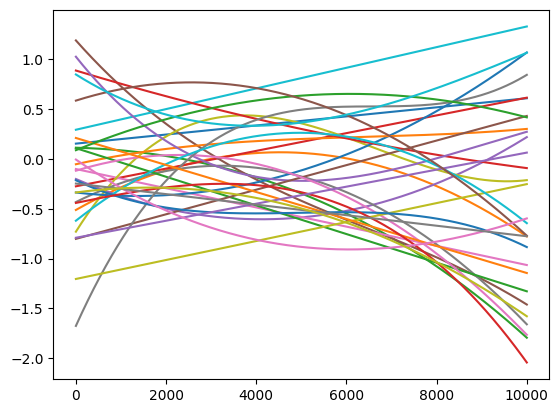

In [14]:
for i in range(10):
    r = np.random.randint(sample_size)
    plt.plot(lin_full[r, :, 0].detach().cpu().numpy(), "-")
    plt.plot(quad_full[r, :, 0].detach().cpu().numpy(), "-")
    plt.plot(cube_full[r, :, 0].detach().cpu().numpy(), "-")

In [97]:
model = Multi_Func(functions=[[linear_function, quadratic_function], [2,3]], x_data=x_values, input_channels=1, device=device).to(device)
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [98]:
def train(dataloader, model, epochs, device):
    for epoch in range(epochs):
        start_time = time.time()
        train_loss = 0.0
        total_num = 0
        model.train()

        for train_batch in dataloader:
            train_batch = train_batch.to(device)
            target_batch = train_batch.squeeze(2).to(device)
            optimizer.zero_grad()
            best_out,_,_,_,_ = model(train_batch)
            loss = loss_func(best_out,target_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * best_out.shape[0]
            total_num += best_out.shape[0]
        scheduler.step()
        train_loss /= total_num
        print(f"epoch : {epoch}/{epochs}, loss = {train_loss:.8f}")
        print(f"--- {time.time() - start_time} seconds ---")

In [99]:
train(lin_data, model, 50, device)

epoch : 0/50, loss = 0.35478332
--- 0.8310384750366211 seconds ---
epoch : 1/50, loss = 0.14210276
--- 0.8107471466064453 seconds ---
epoch : 2/50, loss = 0.07609849
--- 0.8262758255004883 seconds ---
epoch : 3/50, loss = 0.02693279
--- 0.8381860256195068 seconds ---
epoch : 4/50, loss = 0.00539549
--- 0.6796188354492188 seconds ---
epoch : 5/50, loss = 0.00346302
--- 0.9248011112213135 seconds ---
epoch : 6/50, loss = 0.00248885
--- 1.0118486881256104 seconds ---
epoch : 7/50, loss = 0.00190357
--- 0.8157105445861816 seconds ---
epoch : 8/50, loss = 0.00150636
--- 0.8548557758331299 seconds ---
epoch : 9/50, loss = 0.00121705
--- 0.9101412296295166 seconds ---
epoch : 10/50, loss = 0.00108222
--- 0.893439531326294 seconds ---
epoch : 11/50, loss = 0.00106092
--- 0.8671517372131348 seconds ---
epoch : 12/50, loss = 0.00104016
--- 0.8547060489654541 seconds ---
epoch : 13/50, loss = 0.00101908
--- 0.744438886642456 seconds ---
epoch : 14/50, loss = 0.00099784
--- 0.8995435237884521 seco

In [112]:
train(quad_data, model, 50, device)

epoch : 0/50, loss = 0.03183660
--- 0.7170233726501465 seconds ---
epoch : 1/50, loss = 0.03183651
--- 0.6299500465393066 seconds ---
epoch : 2/50, loss = 0.03183641
--- 0.644282341003418 seconds ---
epoch : 3/50, loss = 0.03183630
--- 0.6376917362213135 seconds ---
epoch : 4/50, loss = 0.03183620
--- 0.6080915927886963 seconds ---
epoch : 5/50, loss = 0.03183611
--- 0.6190805435180664 seconds ---
epoch : 6/50, loss = 0.03183602
--- 0.6770014762878418 seconds ---
epoch : 7/50, loss = 0.03183594
--- 0.6770567893981934 seconds ---
epoch : 8/50, loss = 0.03183586
--- 0.6115410327911377 seconds ---
epoch : 9/50, loss = 0.03183578
--- 0.615004301071167 seconds ---
epoch : 10/50, loss = 0.03183574
--- 0.6577560901641846 seconds ---
epoch : 11/50, loss = 0.03183574
--- 0.658470630645752 seconds ---
epoch : 12/50, loss = 0.03183574
--- 0.638378381729126 seconds ---
epoch : 13/50, loss = 0.03183574
--- 0.6137516498565674 seconds ---
epoch : 14/50, loss = 0.03183574
--- 0.651965856552124 seconds

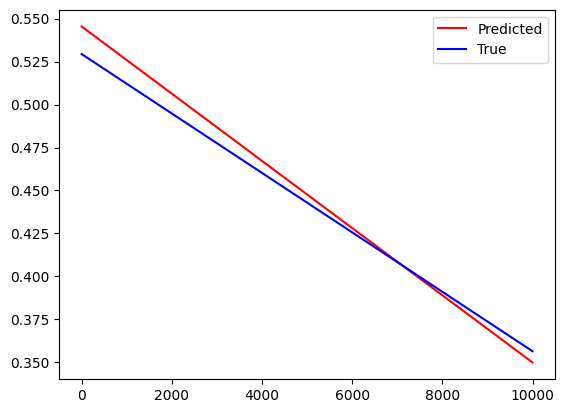

In [111]:
model.eval
data_iter = iter(lin_data)
batch = next(data_iter)
best_out, best_func, best_loss, losses, outputs = model(batch)
rand = np.random.randint(0, batch_size)
plt.plot(best_out[rand, :].detach().cpu().numpy(), "r", label='Predicted')
plt.plot(lin_full[rand, :].detach().cpu().numpy(), "b", label='True')
plt.legend();

<function linear_function at 0x7f1e1fb713a0>
[tensor(0.0323, device='cuda:3', grad_fn=<MseLossBackward0>), tensor(0.3981, device='cuda:3', grad_fn=<MseLossBackward0>)]
tensor(0.0323, device='cuda:3', grad_fn=<MseLossBackward0>)


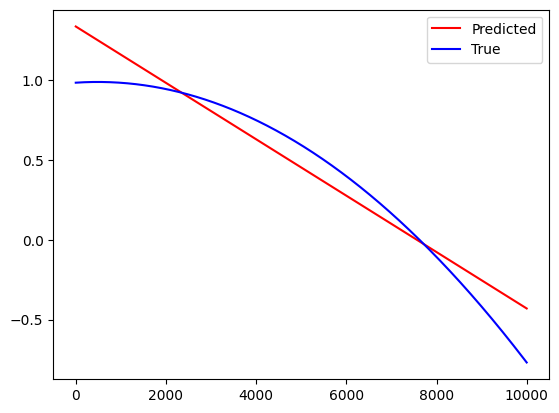

In [133]:
model.eval
data_iter = iter(quad_data)
batch = next(data_iter)
best_out, best_func, best_loss, losses, outputs = model(batch)
rand = np.random.randint(0, batch_size)
plt.plot(best_out[rand, :].detach().cpu().numpy(), "r", label='Predicted')
plt.plot(quad_full[rand, :].detach().cpu().numpy(), "b", label='True')
plt.legend();
print(best_func)
print(losses)
print(best_loss)